# FIT5202 Assignment 1 : Retail Analysis  Solution

## Table of Contents
* 
    * [Part 1 : Working with RDD](#part-1)
        * [1.1 Data Preparation and Loading](#1.1)
        * [1.2 Data Partitioning in RDD](#1.2)
        * [1.3 Query/Analysis](#1.3)
    * [Part 2 : Working with DataFrames](#2-dataframes)
        * [2.1 Data Preparation and Loading](#2-dataframes)
        * [2.2 Query/Analysis](#2.2)
    * [Part 3 :  RDDs vs DataFrame vs Spark SQL](#part-3)

# Part 1 : Working with RDDs <a class="anchor" name="part-1"></a>
## 1. Working with RDD
In this section, you will need to create RDDs from the given datasets, perform partitioning in these RDDs and use various RDD operations to answer the queries for retail analysis. 

### 1.1 Data Preparation and Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkContext object using SparkSession, which tells Spark how to access a cluster. To create a SparkSession you first need to build a SparkConf object that contains information about your application, using Melbourne time as the session timezone. Give an appropriate name for your application and run Spark locally with as many working processors as logical cores on your machine. 

#### Define SparkConf

In [3]:
# Import SparkConf class into program
from pyspark import SparkConf

# the below setup will run Spark in local mode with * working processors (equal to logical cores on the machine)
master = "local[*]"

# Setup `appName` field to be displayed at Spark cluster UI page
app_name = "FIT5202 Assignment 1"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkSession classes
from pyspark.sql import SparkSession  # Spark SQL

#### Setup SparkSession

In [4]:
# Import SparkContext and SparkSession classes
from pyspark import SparkContext  # Spark
from pyspark.sql import SparkSession  # Spark SQL

# Setup SparkSession and configure it with Melbourne timezone.

spark = (
    SparkSession.builder.config(conf=spark_conf)
    .config("spark.sql.session.timeZone", "UTC+11")
    .config("spark.driver.extraJavaOptions", "-Duser.timezone=GMT+11")
    .config("spark.executor.extraJavaOptions", "-Duser.timezone=GMT+11")
    .getOrCreate()
)
sc = spark.sparkContext
sc.setLogLevel("ERROR")

#### Other Configuration

In [5]:
import pprint as pp

from pyspark.rdd import RDD

Note that timezone has [Space for explanation here]

https://stackoverflow.com/questions/49644232/how-to-set-timezone-to-utc-in-apache-spark

#### User Defined Functions

In [6]:
#! Create UDF that prepares and loads the data
def prep_and_load(path):
    """
    Function to create an rdd object and remove the first header row.
    path: relative path to csv file
    """
    # read text file as rdd
    _ = sc.textFile(path)
    # create header
    header = _.first()
    # filter out header
    rdd = _.filter(lambda x: x != header)
    return rdd


def print_items(rdd, name, items):
    """
    Print a given number of items of an rdd object.
    RDD: rdd object
    Name: Table Name
    items: items to be shown
    """
    print("---- {} first {} records ----".format(name, items), "\n")
    print("Total count:", rdd.count())
    pp.pprint(rdd.take(items))
    print(" ")


def print_partitions(data):
    if isinstance(data, RDD):
        numPartitions = data.getNumPartitions()
        partitions = data.glom().collect()
    else:
        # make data an rdd object first
        numPartitions = data.rdd.getNumPartitions()
        partitions = data.rdd.glom().collect()

    print(f"####### NUMBER OF PARTITIONS: {numPartitions}")
    for index, partition in enumerate(partitions):
        # show partition if it is not empty
        if len(partition) > 0:
            pp.pprint(f"Partition {index}: {len(partition)} records")
            pp.pprint(partition)


def schema_display(df, name):
    print("---- {} ----".format(name))
    pp.pprint(df.printSchema())

In [7]:
#! Build a check to make sure its properly changed the timezone.

#### 1.1.2 For each features, sales and stores RDDs, remove the header rows and display the total count and first 10 records. Hint : You can use csv.reader to parse rows in RDDs.

In [8]:
# loading the data into RDD
features_rdd = prep_and_load("data/Features.csv")
sales_rdd = prep_and_load("data/sales.csv")
stores_rdd = prep_and_load("data/stores.csv")

In [9]:
# printing items
print_items(features_rdd, "Features RDD", 10)
print_items(sales_rdd, "Sales RDD", 10)
print_items(stores_rdd, "Stores RDD", 10)

---- Features RDD first 10 records ---- 

Total count: 8190
['1,05/02/2010,42.31,2.572,NA,NA,NA,NA,NA,211.0963582,8.106,FALSE',
 '1,12/02/2010,38.51,2.548,NA,NA,NA,NA,NA,211.2421698,8.106,TRUE',
 '1,19/02/2010,39.93,2.514,NA,NA,NA,NA,NA,211.2891429,8.106,FALSE',
 '1,26/02/2010,46.63,2.561,NA,NA,NA,NA,NA,211.3196429,8.106,FALSE',
 '1,05/03/2010,46.5,2.625,NA,NA,NA,NA,NA,211.3501429,8.106,FALSE',
 '1,12/03/2010,57.79,2.667,NA,NA,NA,NA,NA,211.3806429,8.106,FALSE',
 '1,19/03/2010,54.58,2.72,NA,NA,NA,NA,NA,211.215635,8.106,FALSE',
 '1,26/03/2010,51.45,2.732,NA,NA,NA,NA,NA,211.0180424,8.106,FALSE',
 '1,02/04/2010,62.27,2.719,NA,NA,NA,NA,NA,210.8204499,7.808,FALSE',
 '1,09/04/2010,65.86,2.77,NA,NA,NA,NA,NA,210.6228574,7.808,FALSE']
 
---- Sales RDD first 10 records ---- 

Total count: 421570
['1,1,05/02/2010,24924.5,FALSE',
 '1,1,12/02/2010,46039.49,TRUE',
 '1,1,19/02/2010,41595.55,FALSE',
 '1,1,26/02/2010,19403.54,FALSE',
 '1,1,05/03/2010,21827.9,FALSE',
 '1,1,12/03/2010,21043.39,FALSE',
 '1

In [10]:
#! ask if I should be doing it differently with csv reading (why is it hinted?)

### 1.2 Data Partitioning in RDD <a class="anchor" name="1.2"></a>
#### 1.2.1 How many partitions do the above RDDs have? How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy? Can you explain Why it will be partitioned in this number? Hint: searching the source code to try to understand the reason. 

In [11]:
# check RDD partitions
print("Features RDD partitions:", features_rdd.getNumPartitions())
print("Sales RDD partitions:", sales_rdd.getNumPartitions())
print("Stores RDD partitions:", stores_rdd.getNumPartitions())

Features RDD partitions: 2
Sales RDD partitions: 2
Stores RDD partitions: 2


The reason behind the default number of partitions is suggested in the `textFile` documentation:
```java
/**
   * Read a text file from HDFS, a local file system (available on all nodes), or any
   * Hadoop-supported file system URI, and return it as an RDD of Strings.
   * The text files must be encoded as UTF-8.
   *
   * @param path path to the text file on a supported file system
   * @param minPartitions suggested minimum number of partitions for the resulting RDD
   * @return RDD of lines of the text file
   */
  def textFile(
      path: String,
      minPartitions: Int = defaultMinPartitions): RDD[String] = withScope {
    assertNotStopped()
    hadoopFile(path, classOf[TextInputFormat], classOf[LongWritable], classOf[Text],
      minPartitions).map(pair => pair._2.toString).setName(path)
  }
```

The above code mentions the parameter minPartitions, which implies that 2 partitions seems to be the recommended minimum partition for a hadoop split.

#### 1.2.2. Create a key value RDD for the store RDD, use the store type as the key and all of columns as the value. Print out the first 5 records of the key-value RDD. 

In [12]:
# create a function with to split each line into a key and values.
def parselines(line):
    # split line separated by a comma
    _ = line.split(",")
    # return a tuple with the second element as key and the rest of the information as second element
    return _[1], [_[0], _[2]]

In [13]:
stores_rdd1 = stores_rdd.map(parselines)
print_items(stores_rdd1, "Stores Key-Value", 5)

---- Stores Key-Value first 5 records ---- 

Total count: 45
[('A', ['1', '151315']),
 ('A', ['2', '202307']),
 ('B', ['3', '37392']),
 ('A', ['4', '205863']),
 ('B', ['5', '34875'])]
 


#### 1.2.3. Write the code to seperate the store key-value RDD based on the store type (each type should be in the same partition). Print out the total partition's number and the number of records in each partition. 

In [12]:
# note the hash function is directly applied as it's a fairly straightforward transformacion of characters to numbers/
partitioned_stores = stores_rdd1.partitionBy(3, lambda x: ord(x))

In [13]:
print_partitions(partitioned_stores)

####### NUMBER OF PARTITIONS: 3
'Partition 0: 17 records'
[('B', ['3', '37392']),
 ('B', ['5', '34875']),
 ('B', ['7', '70713']),
 ('B', ['9', '125833']),
 ('B', ['10', '126512']),
 ('B', ['12', '112238']),
 ('B', ['15', '123737']),
 ('B', ['16', '57197']),
 ('B', ['17', '93188']),
 ('B', ['18', '120653']),
 ('B', ['21', '140167']),
 ('B', ['22', '119557']),
 ('B', ['23', '114533']),
 ('B', ['25', '128107']),
 ('B', ['29', '93638']),
 ('B', ['35', '103681']),
 ('B', ['45', '118221'])]
'Partition 1: 6 records'
[('C', ['30', '42988']),
 ('C', ['37', '39910']),
 ('C', ['38', '39690']),
 ('C', ['42', '39690']),
 ('C', ['43', '41062']),
 ('C', ['44', '39910'])]
'Partition 2: 22 records'
[('A', ['1', '151315']),
 ('A', ['2', '202307']),
 ('A', ['4', '205863']),
 ('A', ['6', '202505']),
 ('A', ['8', '155078']),
 ('A', ['11', '207499']),
 ('A', ['13', '219622']),
 ('A', ['14', '200898']),
 ('A', ['19', '203819']),
 ('A', ['20', '203742']),
 ('A', ['24', '203819']),
 ('A', ['26', '152513']),
 (

### 1.3 Query/Analysis <a class="anchor" name="1.3"></a>
For this part, write relevant RDD operations to answer the following queries.

**1.3.1 Calculate the average weekly sales for each year.**

In [14]:
# create UDFs


def get_year(line):
    line[2] = line[2][-4:]
    return line

In [15]:
# data prep
sales_rdd = (
    prep_and_load("data/sales.csv")
    .map(lambda x: x.split(","))
    .map(lambda x: get_year(x))
    .map(lambda x: (x[2], float(x[3])))
)

In [16]:
print_items(sales_rdd, "Sales", 5)

---- Sales first 5 records ---- 

Total count: 421570
[('2010', 24924.5),
 ('2010', 46039.49),
 ('2010', 41595.55),
 ('2010', 19403.54),
 ('2010', 21827.9)]
 


In [17]:
# solution from book
# need to undersand solution more deeply.
Avgsales_RDD = (
    sales_rdd.map(lambda x: (x[0], (x[1], 1)))
    .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    .map(lambda x: (x[0], x[1][0] / x[1][1]))
    .collect()
)

In [18]:
Avgsales_RDD

[('2010', 16270.27573703275),
 ('2011', 15954.070675386221),
 ('2012', 15694.948597357119)]

<div style="background:rgba(255,181,116,0.5);padding:10px">
    <strong>NOTE:</strong> Other ways are also acceptable if they can get the correct result. 
    

</div>

**1.3.2 Find the highest temperature record in 2011 in the 'type B' store. You should display the store ID, date, highest temperature and type in the result.**

In [19]:
# Prepare Stores RDD

stores_RDD = (
    prep_and_load("data/stores.csv")
    .map(lambda x: x.split(","))
    .map(lambda x: (x[0], x[1]))
)

print_items(stores_RDD, "Stores", 5)

---- Stores first 5 records ---- 

Total count: 45
[('1', 'A'), ('2', 'A'), ('3', 'B'), ('4', 'A'), ('5', 'B')]
 


In [20]:
features_RDD = (
    prep_and_load("data/Features.csv")
    .map(lambda x: x.split(","))
    .map(lambda x: x[0:3])
    .map(lambda x: (x[0], (x[1][-4:], float(x[2]))))
)

print_items(features_RDD, "Features", 4)

---- Features first 4 records ---- 

Total count: 8190
[('1', ('2010', 42.31)),
 ('1', ('2010', 38.51)),
 ('1', ('2010', 39.93)),
 ('1', ('2010', 46.63))]
 


In [21]:
# join Store types to Features

Features_RDD2 = (
    features_RDD.join(stores_RDD)
    .map(lambda x: ([x[0]] + list((x[1][0][0], x[1][0][1], x[1][1]))))
    .filter(lambda x: x[3] == "B" and x[1] == "2011")
    .max(lambda x: x[2])
)

In [22]:
Features_RDD2

['10', '2011', 95.36, 'B']

## Part 2. Working with DataFrames <a class="anchor" name="2-dataframes"></a>
In this section, you will need to load the given datasets into PySpark DataFrames and use DataFrame functions to answer the queries.
### 2.1 Data Preparation and Loading

**2.1.1. Load features, sales and stores data into three separate dataframes. When you create your dataframes, please refer to the metadata file and think about the appropriate data type for each columns (Note: you could directly read the date column as the string type)**

In [23]:
# setup
import matplotlib.pyplot as plt
import pyspark.pandas as ps
import pyspark.sql.functions as F
from pyspark.sql.functions import col, lit, to_date, to_timestamp
from pyspark.sql.types import (
    BooleanType,
    FloatType,
    IntegerType,
    NumericType,
    StringType,
    StructField,
    StructType,
)

In [24]:
# create a list comprehension for loading the data with correct data types.

features_labels = [
    ("Store", StringType()),
    ("Date", StringType()),
    ("Temperature", FloatType()),
    ("Fuel_Price", FloatType()),
    ("MarkDown1", FloatType()),
    ("MarkDown2", FloatType()),
    ("MarkDown3", FloatType()),
    ("MarkDown4", FloatType()),
    ("MarkDown5", FloatType()),
    ("CPI", FloatType()),
    ("Unemployment", FloatType()),
    ("IsHoliday", BooleanType()),
]

sales_labels = [
    ("Store", StringType()),
    ("Dept", StringType()),
    ("Date", StringType()),
    ("Weekly_Sales", FloatType()),
    ("IsHoliday", BooleanType()),
]

stores_labels = [
    ("Store", StringType()),
    ("Type", StringType()),
    ("Size", IntegerType()),
]

features_schema = StructType([StructField(x[0], x[1], True) for x in features_labels])
sales_schema = StructType([StructField(x[0], x[1], True) for x in sales_labels])
stores_schema = StructType([StructField(x[0], x[1], True) for x in stores_labels])

In [25]:
# read with utf-8 encoding.

df_features = (
    spark.read.format("csv")
    .option("header", True)
    .option("encoding", "UTF-8")
    .load("data/Features.csv", schema=features_schema)
)

df_sales = (
    spark.read.format("csv")
    .option("header", True)
    .option("encoding", "UTF-8")
    .load("data/sales.csv", schema=sales_schema)
)

df_stores = (
    spark.read.format("csv")
    .option("header", True)
    .option("encoding", "UTF-8")
    .load("data/stores.csv", schema=stores_schema)
)


**2.1.2 Display the schema of the features, sales and stores dataframes.**

In [26]:
# print schema
schema_display(df_features, "Features DF Schema")
schema_display(df_sales, "Sales DF Schema")
schema_display(df_stores, "Stores DF Schema")

---- Features DF Schema ----
root
 |-- Store: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Temperature: float (nullable = true)
 |-- Fuel_Price: float (nullable = true)
 |-- MarkDown1: float (nullable = true)
 |-- MarkDown2: float (nullable = true)
 |-- MarkDown3: float (nullable = true)
 |-- MarkDown4: float (nullable = true)
 |-- MarkDown5: float (nullable = true)
 |-- CPI: float (nullable = true)
 |-- Unemployment: float (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

None
---- Sales DF Schema ----
root
 |-- Store: string (nullable = true)
 |-- Dept: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Weekly_Sales: float (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

None
---- Stores DF Schema ----
root
 |-- Store: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)

None


### 2.2 QueryAnalysis  <a class="anchor" name="2.2"></a>
Implement the following queries using dataframes. You need to be able to perform operations like filtering, sorting, joining and group by using the functions provided by the DataFrame API. The following DF means dataframes.

**2.2.1. Transform 'Date' column in both feature and sales dataframe to the date type, after that print out these two DFs schema to show the results.**

In [27]:
# transform features date field to date type
df_features = df_features.withColumn("Date", to_date(col("Date"), "d/M/y"))
# transform sales date field to date type
df_sales = df_sales.withColumn("Date", to_date(col("Date"), "d/M/y"))

In [28]:
# print schema
schema_display(df_features, "Features DF")
schema_display(df_sales, "Sales DF")

---- Features DF ----
root
 |-- Store: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Temperature: float (nullable = true)
 |-- Fuel_Price: float (nullable = true)
 |-- MarkDown1: float (nullable = true)
 |-- MarkDown2: float (nullable = true)
 |-- MarkDown3: float (nullable = true)
 |-- MarkDown4: float (nullable = true)
 |-- MarkDown5: float (nullable = true)
 |-- CPI: float (nullable = true)
 |-- Unemployment: float (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

None
---- Sales DF ----
root
 |-- Store: string (nullable = true)
 |-- Dept: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Weekly_Sales: float (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

None


**2.2.2. Calculate the average weekly sales for holiday week and non-holiday week seperately, order your result based on the average weekly sales in descending order. Print out the IsHoliday and average sales columns**

In [29]:
df_sales_avg = (
    df_sales.groupby("IsHoliday")
    .agg(F.mean("Weekly_Sales").alias("average sales"))
    .orderBy("average sales")
)

df_sales_avg.show()

+---------+------------------+
|IsHoliday|     average sales|
+---------+------------------+
|    false|15901.445067351051|
|     true|17035.823179236566|
+---------+------------------+



**2.2.3.Based on different years and months, calculate the average weekly sales.**

In [30]:
df_sales_avg2 = (
    df_sales.withColumn("Year", F.year(col("Date")))
    .withColumn("Month", F.month(col("Date")))
    .groupby("Year", "Month")
    .agg(F.mean("Weekly_Sales").alias("average sales"))
    .orderBy("Year", "Month")
)

In [31]:
df_sales_avg2.show()

+----+-----+------------------+
|Year|Month|     average sales|
+----+-----+------------------+
|2010|    2| 16076.77870097281|
|2010|    3|15432.626605889885|
|2010|    4|15745.551349035144|
|2010|    5|15996.481697140169|
|2010|    6|16486.250949284375|
|2010|    7|15972.812711132709|
|2010|    8|16171.689294409856|
|2010|    9|15120.086680005943|
|2010|   10|14806.151500089774|
|2010|   11|17320.130640785745|
|2010|   12|19570.351259788942|
|2011|    1|13997.773982892584|
|2011|    2|15870.141205563425|
|2011|    3|15182.972004079187|
|2011|    4| 15361.89548697221|
|2011|    5| 15367.86447580668|
|2011|    6| 16188.12464341475|
|2011|    7|15724.738315017767|
|2011|    8| 16030.54247852901|
|2011|    9| 14961.57024559697|
+----+-----+------------------+
only showing top 20 rows



**2.2.4. Calculate the average MarkDown1 value in holiday week for all type C store.**

In [32]:
df_features_avg = (
    df_features.join(df_stores, df_features.Store == df_stores.Store, how="left")
    .filter(col("Type") == "C")
    .filter(col("IsHoliday") == True)
    .agg(F.mean("MarkDown1").alias("Average Markdown 1 Value"))
)

In [33]:
df_features_avg.show()

+------------------------+
|Average Markdown 1 Value|
+------------------------+
|       778.2502325918616|
+------------------------+



**2.2.5.show all stores total sales based on each different month and yearly total for each different store, only keep two decimal places after the decimal point.**

In [34]:
df_sales_bystore = (
    df_sales.withColumn("Year", F.year(col("Date")))
    .withColumn("Month", F.month(col("Date")))
    .groupby("Store", "Year", "Month")
    .agg(F.sum("Weekly_Sales").alias("Total Sales"))
    .withColumn("Total Sales", F.bround("Total Sales", 2))
    .orderBy("Store", "Year", "Month")
)

In [35]:
df_sales_bystore.show()

+-----+----+-----+-----------+
|Store|Year|Month|Total Sales|
+-----+----+-----+-----------+
|    1|2010|    2| 6307344.11|
|    1|2010|    3| 5871293.99|
|    1|2010|    4| 7422801.96|
|    1|2010|    5| 5929938.66|
|    1|2010|    6| 6084081.46|
|    1|2010|    7| 7244483.04|
|    1|2010|    8| 6075952.96|
|    1|2010|    9| 5829793.94|
|    1|2010|   10| 7150641.75|
|    1|2010|   11| 6485547.08|
|    1|2010|   12| 8876953.18|
|    1|2011|    1| 5480050.95|
|    1|2011|    2| 6399887.56|
|    1|2011|    3|  6307375.5|
|    1|2011|    4| 7689123.63|
|    1|2011|    5| 6128431.79|
|    1|2011|    6| 6194971.69|
|    1|2011|    7| 7227654.29|
|    1|2011|    8| 6144985.74|
|    1|2011|    9| 7379542.37|
+-----+----+-----+-----------+
only showing top 20 rows



##### **2.2.6. Draw a scatter plot to show the relationship between weekly sales and unemployment rate, use the different color for the holiday week point. After that, discuss your findings based on the scatter plot**

In [36]:
df_sales.show(5)

+-----+----+----------+------------+---------+
|Store|Dept|      Date|Weekly_Sales|IsHoliday|
+-----+----+----------+------------+---------+
|    1|   1|2010-02-05|     24924.5|    false|
|    1|   1|2010-02-12|    46039.49|     true|
|    1|   1|2010-02-19|    41595.55|    false|
|    1|   1|2010-02-26|    19403.54|    false|
|    1|   1|2010-03-05|     21827.9|    false|
+-----+----+----------+------------+---------+
only showing top 5 rows



In [37]:
# First the weekly sales need to be aggregated by week, not by store
df_sales_byweek = (
    df_sales.groupby("Date", "IsHoliday")
    .agg(F.sum("Weekly_Sales").alias("Total Sales (Millions)"))
    .withColumn(
        "Total Sales (Millions)", F.bround(col("Total Sales (Millions)") / 10**6, 2)
    )
    .orderBy("Date")
    .withColumnRenamed("Date", "Sales_Date")
)
# check
df_sales_byweek.show(5)

+----------+---------+----------------------+
|Sales_Date|IsHoliday|Total Sales (Millions)|
+----------+---------+----------------------+
|2010-02-05|    false|                 49.75|
|2010-02-12|     true|                 48.34|
|2010-02-19|    false|                 48.28|
|2010-02-26|    false|                 43.97|
|2010-03-05|    false|                 46.87|
+----------+---------+----------------------+
only showing top 5 rows



In [38]:
df_sales_byweek2 = (
    df_sales_byweek.join(
        df_features.select("Date", "Unemployment"),
        df_sales_byweek.Sales_Date == df_features.Date,
        how="right",
    )
    .drop("Date")
    .toPandas()
)

Text(0.5, 1.0, 'Relationship Between Unemployment and Sales')

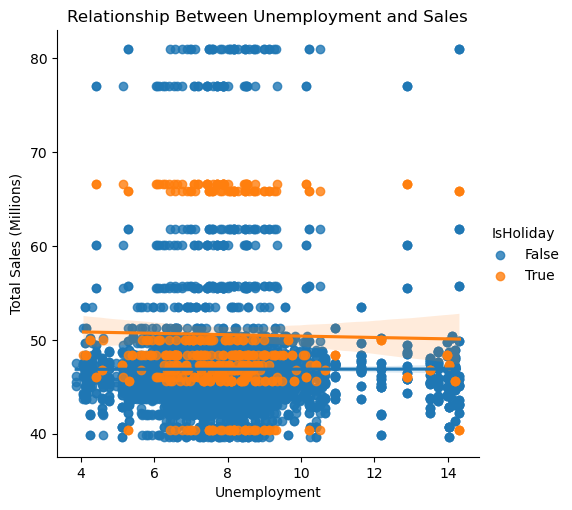

In [39]:
# export to Pandas
import seaborn as sns

# use the function regplot to make a scatterplot

sns.lmplot(
    df_sales_byweek2, y="Total Sales (Millions)", x="Unemployment", hue="IsHoliday"
)

plt.title("Relationship Between Unemployment and Sales")

<div style="background:rgba(255,181,116,0.5);padding:10px">
    <strong>NOTE:</strong> When the unemployment rate is larger than 10, it will have a big influence on weekly sales. 

</div>

## Part 3 RDDs vs DataFrame vs Spark SQL (15%) <a class="anchor" name="part-3"></a>
Implement the following queries using RDDs, DataFrames and SparkSQL separately. Log the time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the performance difference of these 3 approaches.


Why DF is faster than RDD? 

### Query: Calculate the average weekly fuel price for all stores' size larger than 150000.

In [45]:
# Prepare Features RDD
features_RDD2 = (
    prep_and_load("data/Features.csv")
    .map(lambda x: x.split(","))
    .map(lambda x: x[0:4])
    .map(lambda x: (x[0], float(x[3])))
)
# Prepare Stores RDD
stores_RDD2 = (
    prep_and_load("data/stores.csv")
    .map(lambda x: x.split(","))
    .map(lambda x: (x[0], float(x[2])))
)

df_features = (
    spark.read.format("csv")
    .option("header", True)
    .option("encoding", "UTF-8")
    .load("data/Features.csv", schema=features_schema)
    .withColumnRenamed("Store", "Features_store")
)

df_stores = (
    spark.read.format("csv")
    .option("header", True)
    .option("encoding", "UTF-8")
    .load("data/stores.csv", schema=stores_schema)
)

# Create Views from Dataframes
df_features.createOrReplaceTempView("sql_features")
df_stores.createOrReplaceTempView("sql_stores")

### 3.1. For RDD

In [41]:
%%time
# Join RDDs, rounding results
features_RDD_timed = (
    features_RDD2.join(stores_RDD2)
    .map(lambda x: ([x[0]] + list((x[1][0], x[1][1]))))
    .filter(lambda x: x[2] > 150000)
    .map(lambda x: (x[0], (x[1], 1)))
    .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    .map(lambda x: (x[0], x[1][0] / x[1][1]))
    .collect()
)

# Reduce by key to calculate weekly stores

CPU times: user 16.6 ms, sys: 6.45 ms, total: 23.1 ms
Wall time: 188 ms


### 3.2. For DataFrame

In [42]:
%%time

df_features_avg2 = (
    df_features.join(
        df_stores, df_features.Features_store == df_stores.Store, how="left"
    )
    .drop("Features_Store")
    .filter(col("Size") > 150000)
    .groupby("Store")
    .agg(F.mean("Fuel_Price"))
)

CPU times: user 5.32 ms, sys: 355 µs, total: 5.68 ms
Wall time: 43.4 ms


### 3.3. For Spark SQL

In [43]:
%%time
# Create Views from Dataframes
df_features_avg3 = spark.sql(
    """
    SELECT f.Features_store, AVG(f.Fuel_Price) AS avg_price
    FROM sql_features f LEFT JOIN sql_stores s
    ON f.Features_store=s.Store
    WHERE Size > 150000
    GROUP BY f.Features_store
"""
)

CPU times: user 2.39 ms, sys: 1.28 ms, total: 3.67 ms
Wall time: 44.2 ms


In [44]:
df_features_avg3.show()

+--------------+------------------+
|Features_store|         avg_price|
+--------------+------------------+
|            11| 3.259241756502089|
|            34|3.2548846163592495|
|             8| 3.259241756502089|
|            28| 3.643653839499086|
|            31| 3.259241756502089|
|            27| 3.643357140677316|
|            26|3.4978736206725403|
|             6| 3.259241756502089|
|            19| 3.643357140677316|
|            41| 3.294401099393656|
|            40|3.4978736206725403|
|            24| 3.643357140677316|
|            32| 3.294401099393656|
|             1| 3.259241756502089|
|            20| 3.476412084076431|
|             4|3.2548846163592495|
|            39| 3.259241756502089|
|            13|3.3287637377833272|
|            14| 3.476412084076431|
|             2| 3.259241756502089|
+--------------+------------------+



#### Summary

The time might differ when running on different machines. Overall, the DataFrame and SQL queries run ...... compared with RDD.


### Some ideas on the comparison

Armbrust, M., Huai, Y., Liang, C., Xin, R., & Zaharia, M. (2015). Deep Dive into Spark SQL’s Catalyst Optimizer. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html

Damji, J. (2016). A Tale of Three Apache Spark APIs: RDDs, DataFrames, and Datasets. Retrieved September 28, 2017, from https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html

Data Flair (2017a). Apache Spark RDD vs DataFrame vs DataSet. Retrieved September 28, 2017, from http://data-flair.training/blogs/apache-spark-rdd-vs-dataframe-vs-dataset

Prakash, C. (2016). Apache Spark: RDD vs Dataframe vs Dataset. Retrieved September 28, 2017, from http://why-not-learn-something.blogspot.com.au/2016/07/apache-spark-rdd-vs-dataframe-vs-dataset.html

Xin, R., & Rosen, J. (2015). Project Tungsten: Bringing Apache Spark Closer to Bare Metal. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html